# **Wasserstein Generative Adversarial Network on the MNIST fashion dataset**

W-GAN trained to approximate the distribution of the MNIST fashion dataset

Necessary file downloads

In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-06-22 05:32:32--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.126
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  11.6MB/s    in 2.2s    

2019-06-22 05:32:35 (11.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-06-22 05:32:36--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.138
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

In [0]:
!mkdir mnist_fashion
!cp *.gz mnist_fashion/

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_fashion/')

W0622 05:32:54.447988 140461342128000 deprecation.py:323] From <ipython-input-3-ecda65ec00a1>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0622 05:32:54.449774 140461342128000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0622 05:32:54.451808 140461342128000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting mnist_fashion/train-images-idx3-ubyte.gz


W0622 05:32:54.828689 140461342128000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0622 05:32:54.897575 140461342128000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting mnist_fashion/train-labels-idx1-ubyte.gz
Extracting mnist_fashion/t10k-images-idx3-ubyte.gz
Extracting mnist_fashion/t10k-labels-idx1-ubyte.gz


**Hyperparameters**

1.   lr : Learning rate set to 0.0002 for the Adam optimizer
2.   epochs : Number of training epochs
3.   batch_size : batch size
3.   image_dim : Dimension of flattened $28*28$ MNIST fashion image
4.   gen_dim : Dimension of Generator hidden layer
5.   dis_dim : Dimension of Discriminator hidden layer
7.   z_dim : Dimension of Generator noise


In [0]:
lr = 2e-4
batch_size = 128
epochs = 100000
image_dim = 784
gen_dim = 256
dis_dim = 256
z_dim = 100

Xavier initialization, given by $1/{\sqrt{\frac{n}{2}}}$ where $n$ represents input dimension

In [0]:
def Xavier(in_shape):
  return tf.random_normal(shape = in_shape, stddev = 1./tf.sqrt(in_shape[0]/2.))

Essential weights and biases

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
weights = {
    'dis_h' : tf.Variable(Xavier([image_dim, dis_dim])),
    'dis_final' : tf.Variable(Xavier([dis_dim, 1])),
    'gen_h' : tf.Variable(Xavier([z_dim, gen_dim])),
    'gen_final' : tf.Variable(Xavier([gen_dim, image_dim]))
}
bias = {
    'dis_h' : tf.Variable(Xavier([dis_dim])),
    'dis_final' : tf.Variable(Xavier([1])),
    'gen_h' : tf.Variable(Xavier([gen_dim])),
    'gen_final' : tf.Variable(Xavier([image_dim]))
}

Unlike a regular GAN, the discriminator now acts as a critic to compute and compare the Wasserstein distance

In [0]:
def Discriminator(x):
  hidden = tf.nn.relu(tf.add(tf.matmul(x, weights['dis_h']), bias['dis_h']))
  final = tf.add(tf.matmul(hidden, weights['dis_final']), bias['dis_final'])
  return (final)

We define the Generator as a simple hidden layer FC network with the output dimension the same as the image dimension we wish to generate

In [0]:
def Generator(x):
  hidden = tf.nn.relu(tf.add(tf.matmul(x, weights['gen_h']), bias['gen_h']))
  final = tf.add(tf.matmul(hidden, weights['gen_final']), bias['gen_final'])
  out = tf.nn.sigmoid(final)
  return out

Define the noise and input placeholders respectively

In [0]:
z_in = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'noise')
x_in = tf.placeholder(tf.float32, shape = [None, image_dim], name = 'input')

In [0]:
with tf.name_scope("Generator") as scope:
  out_gen = Generator(z_in)
with tf.name_scope("Discriminator") as scope:
  real_dis = Discriminator(x_in)
  fake_dis = Discriminator(out_gen)

The discriminator and the generator loss functions are defined as follows

$L_d = - (E_x(D_w(x)) - E_z(D_w(G(z))))$ 

$L_g = E_z(D_w(G(z)))$

The discriminator tries to maximize the Wasserstein distance using the Wasserstein approximation while the generator tries to maximise the expectation of the critic's interpretation of the generator distribution 

In [0]:
eps = 1e-5
with tf.name_scope("Dis_loss") as scope:
  disloss = tf.reduce_mean(real_dis) - tf.reduce_mean(fake_dis)
with tf.name_scope("Gen_loss") as scope:
  genloss = -tf.reduce_mean(fake_dis)

dis_loss_total = tf.summary.scalar("dis_total_loss", disloss)
gen_loss_total = tf.summary.scalar("gen_total_loss", genloss)

In [0]:
gen_var = [weights['gen_h'], weights['gen_final'], bias['gen_h'], bias['gen_final']]
dis_var = [weights['dis_h'], weights['dis_final'], bias['dis_h'], bias['dis_final']]

Optimize the parameters of the adversarial networks separately

In [13]:
with tf.name_scope("opt_dis") as scope:
  disopt = tf.train.RMSPropOptimizer(learning_rate = lr).minimize(-disloss, var_list = dis_var)
with tf.name_scope("opt_gen") as scope:
  genopt = tf.train.RMSPropOptimizer(learning_rate = lr).minimize(genloss, var_list = gen_var)

W0622 05:32:55.560062 140461342128000 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In order for the Wasserstein approximation to hold, we require a smoothened loss curve, which necessiates gradient clipping

In [0]:
clip_dis = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in dis_var]

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter('./log', sess.graph)

The paper recommends more intensive training of the critic network. We run the critic optimizer 5 times each epoch to implement this. 

In [16]:
for epoch in range(epochs):
  for _ in range(5):
    x_batch, _ = mnist.train.next_batch(batch_size) 
    z_noise = np.random.uniform(-1., 1., size = [batch_size, z_dim])
    _, dis_loss_epoch, dis_clip = sess.run([disopt, disloss,clip_dis], feed_dict = {x_in : x_batch, z_in : z_noise})
  _, gen_loss_epoch = sess.run([genopt, genloss], feed_dict = {z_in : z_noise})
  dis_summary = sess.run(dis_loss_total, feed_dict = {x_in : x_batch, z_in : z_noise})
  writer.add_summary(dis_summary, epoch)
  gen_summary = sess.run(gen_loss_total, feed_dict = {z_in : z_noise})
  writer.add_summary(gen_summary, epoch)
  
  if epoch%2000 == 0:
    print("Step : {0}, Generator loss : {1}, Discriminator loss : {2}".format(epoch, gen_loss_epoch, dis_loss_epoch))
  

Step : 0, Generator loss : 0.15705008804798126, Discriminator loss : -0.09565216302871704
Step : 2000, Generator loss : 0.032520659267902374, Discriminator loss : 2.0399889945983887
Step : 4000, Generator loss : -3.5177035331726074, Discriminator loss : 1.0709519386291504
Step : 6000, Generator loss : 4.4702253341674805, Discriminator loss : 1.3379673957824707
Step : 8000, Generator loss : 0.7786929607391357, Discriminator loss : 1.459078073501587
Step : 10000, Generator loss : -4.919397830963135, Discriminator loss : 1.4652976989746094
Step : 12000, Generator loss : 0.2768940329551697, Discriminator loss : 1.5756113529205322
Step : 14000, Generator loss : -0.8504126071929932, Discriminator loss : 1.2252225875854492
Step : 16000, Generator loss : 1.758014440536499, Discriminator loss : 1.2470028400421143
Step : 18000, Generator loss : -2.4075167179107666, Discriminator loss : 0.9553072452545166
Step : 20000, Generator loss : -7.365785121917725, Discriminator loss : 1.438612461090088
St

Visualise the output with a $6\times6$ grid of noise fed into the generator

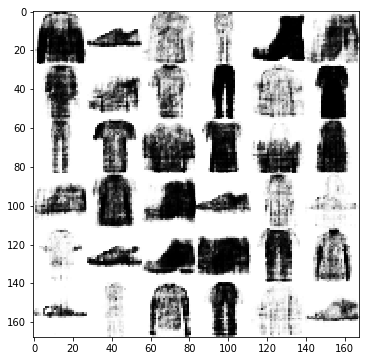

In [17]:
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  z_noise = np.random.uniform(-1., 1., size = [batch_size, z_dim])
  g = sess.run(out_gen, feed_dict = {z_in : z_noise})
  g = -1*(g - 1)
  for j in range(n):
    canvas[i*28:(i + 1)*28, j*28:(j+1)*28] = g[j].reshape(28,28)
  
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin= "upper", cmap = "gray")